In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import os
import statsmodels.api as sm
import warnings
import matplotlib.pyplot as plt
import math
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Model, Sequential
from keras.layers import GRU, Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

C:\Users\Kushal\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Kushal\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\Kushal\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Kushal\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [4]:
data = pd.read_excel('C:/Users/Kushal/Desktop/Energy forecasting/GEFCom2014 Data/GEFCom2014-E_V2/GEFCom2014-E.xlsx',sheet_name='Hourly')
data = data.dropna()
data.Date +=  pd.to_timedelta(data.Hour, unit='h')
data = data.set_index('Date')
ts_data = data.copy()
ts_data = ts_data[['load','T']]
ts_data_load = ts_data['load']
ts_data.dtypes

load    float64
T       float64
dtype: object

In [5]:
ts_data.describe()

,load,T
count,78888.000000,78888.000000
mean,3308.000837,47.573928
std,579.803021,19.201312
min,1811.000000,-18.000000
25%,2845.000000,32.666667
50%,3382.000000,48.666667
75%,3709.000000,63.000000
max,5506.000000,97.000000


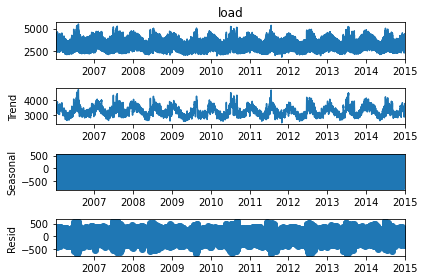

In [6]:
decomposition = sm.tsa.seasonal_decompose(ts_data_load, model = 'additive')
fig = decomposition.plot()

In [7]:
valid_st_data_load = "2014-09-01 00:00:00"
test_st_data_load = "2014-11-01 00:00:00"

In [8]:
# LAGGED VARIABLES SET TO 12
T = 12
HORIZON = 1
train = pd.DataFrame(ts_data_load.copy()[ts_data_load.index < valid_st_data_load])[["load"]]
scaler = MinMaxScaler()
train["load"] = scaler.fit_transform(train)
train_shifted = train.copy()
train_shifted["y_t+1"] = train_shifted["load"].shift(-1, freq="H")
for t in range(1, T + 1):
    train_shifted[str(T - t)] = train_shifted["load"].shift(T - t, freq="H")
y_col = "y_t+1"
X_cols = ["load_t-11","load_t-10","load_t-9","load_t-8","load_t-7",
          "load_t-6","load_t-5", "load_t-4", 
          "load_t-3", "load_t-2", "load_t-1", "load_t"]
train_shifted.columns = ["load_original"] + [y_col] + X_cols
train_shifted = train_shifted.dropna(how="any")
train_shifted.head(5)

,load_original,y_t+1,load_t-11,load_t-10,load_t-9,load_t-8,load_t-7,load_t-6,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
Date,,,,,,,,,,,,,,
2006-01-01 12:00:00,0.503924,0.509878,0.324493,0.282003,0.256292,0.241949,0.243031,0.254939,0.280920,0.323951,0.387551,0.448444,0.483627,0.503924
2006-01-01 13:00:00,0.509878,0.494993,0.282003,0.256292,0.241949,0.243031,0.254939,0.280920,0.323951,0.387551,0.448444,0.483627,0.503924,0.509878
2006-01-01 14:00:00,0.494993,0.482003,0.256292,0.241949,0.243031,0.254939,0.280920,0.323951,0.387551,0.448444,0.483627,0.503924,0.509878,0.494993
2006-01-01 15:00:00,0.482003,0.491204,0.241949,0.243031,0.254939,0.280920,0.323951,0.387551,0.448444,0.483627,0.503924,0.509878,0.494993,0.482003
2006-01-01 16:00:00,0.491204,0.571854,0.243031,0.254939,0.280920,0.323951,0.387551,0.448444,0.483627,0.503924,0.509878,0.494993,0.482003,0.491204


In [9]:
# Step: transform this pandas dataframe into a numpy array
y_train = train_shifted[y_col].to_numpy()
X_train = train_shifted[X_cols].to_numpy()
X_train = X_train.reshape(X_train.shape[0], T, 1)
y_train.shape
y_train[:3]
X_train.shape
X_train[:3]
train_shifted.head(3)

,load_original,y_t+1,load_t-11,load_t-10,load_t-9,load_t-8,load_t-7,load_t-6,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
Date,,,,,,,,,,,,,,
2006-01-01 12:00:00,0.503924,0.509878,0.324493,0.282003,0.256292,0.241949,0.243031,0.254939,0.280920,0.323951,0.387551,0.448444,0.483627,0.503924
2006-01-01 13:00:00,0.509878,0.494993,0.282003,0.256292,0.241949,0.243031,0.254939,0.280920,0.323951,0.387551,0.448444,0.483627,0.503924,0.509878
2006-01-01 14:00:00,0.494993,0.482003,0.256292,0.241949,0.243031,0.254939,0.280920,0.323951,0.387551,0.448444,0.483627,0.503924,0.509878,0.494993


In [11]:
look_back_dt = dt.datetime.strptime(valid_st_data_load, "%Y-%m-%d %H:%M:%S") - dt.timedelta(hours=T - 1)
valid = pd.DataFrame(ts_data_load.copy()[(ts_data_load.index >= look_back_dt) & (ts_data_load.index < test_st_data_load)])[["load"]]
valid["load"] = scaler.transform(valid)

valid_shifted = valid.copy()
valid_shifted["y+1"] = valid_shifted["load"].shift(-1, freq="H")
for t in range(1, T + 1):
    valid_shifted["load_t-" + str(T - t)] = valid_shifted["load"].shift(T - t, freq="H")

valid_shifted = valid_shifted.dropna(how="any")
valid_shifted.head(3)

y_valid = valid_shifted['y+1'].to_numpy()
X_valid = valid_shifted[["load_t-" + str(T - t) for t in range(1, T + 1)]].to_numpy()
X_valid = X_valid.reshape(X_valid.shape[0], T, 1)


In [12]:
# RUNNING THE GRU

LATENT_DIM = 5
BATCH_SIZE = 32
EPOCHS = 10

model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 1)))
model.add(Dense(HORIZON))
model.compile(optimizer="RMSprop", loss="mse")
model.summary()


earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

model_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_valid, y_valid),
    callbacks=[earlystop],
    verbose=1,
)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 5)                 120       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 126
Trainable params: 126
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2374/2374 [==============================] - 33s 6ms/step - loss: 0.0276 - val_loss: 6.0587e-04
Epoch 2/10
2374/2374 [==============================] - 13s 5ms/step - loss: 6.4152e-04 - val_loss: 4.6174e-04
Epoch 3/10
2374/2374 [==============================] - 13s 5ms/step - loss: 4.9016e-04 - val_loss: 4.1513e-04
Epoch 4/10
2374/2374 [==============================] - 13s 5ms/step - loss: 4.7115e-04 - val_loss: 6.0688e-04
Epoch 5/10
2374/2374 [==============================] - 12s 5ms/step - loss: 4.7

In [13]:
# TEST SET

look_back_dt = dt.datetime.strptime(test_st_data_load, "%Y-%m-%d %H:%M:%S") - dt.timedelta(hours=T - 1)
test = pd.DataFrame(ts_data_load.copy()[test_st_data_load:])
test["load"] = scaler.transform(test)
test_shifted = test.copy()
test_shifted["y_t+1"] = test_shifted["load"].shift(-1, freq="H")
for t in range(1, T + 1):
    test_shifted["load_t-" + str(T - t)] = test_shifted["load"].shift(T - t, freq="H")
test_shifted = test_shifted.dropna(how="any")
y_test = test_shifted["y_t+1"].to_numpy()
X_test = test_shifted[["load_t-" + str(T - t) for t in range(1, T + 1)]].to_numpy()
X_test = X_test.reshape(X_test.shape[0], T, 1)

y_test.shape
X_test.shape

(1453, 12, 1)

In [14]:
ts_predictions = model.predict(X_test)
ts_predictions

array([[0.45216903],
       [0.45767513],
       [0.4359686 ],
       ...,
       [0.51579344],
       [0.45744702],
       [0.42004722]], dtype=float32)

In [15]:
ev_ts_data = pd.DataFrame(ts_predictions, columns=["t+" + str(t) for t in range(1, HORIZON + 1)])
ev_ts_data["timestamp"] = test_shifted.index
ev_ts_data = pd.melt(ev_ts_data, id_vars="timestamp", value_name="prediction", var_name="h")
ev_ts_data["actual"] = np.transpose(y_test).ravel()
ev_ts_data[["prediction", "actual"]] = scaler.inverse_transform(ev_ts_data[["prediction", "actual"]])
ev_ts_data.head()

,timestamp,h,prediction,actual
0,2014-11-01 11:00:00,t+1,3481.764569,3464.0
1,2014-11-01 12:00:00,t+1,3502.109602,3439.0
2,2014-11-01 13:00:00,t+1,3421.904005,3407.0
3,2014-11-01 14:00:00,t+1,3420.342840,3389.0
4,2014-11-01 15:00:00,t+1,3404.594088,3402.0


In [17]:
def mape(ts_predictions, actuals):
    """Mean absolute percentage error"""
    return ((ts_predictions - actuals).abs() / actuals).mean()

print('MAPE: ',mape(ev_ts_data["prediction"], ev_ts_data["actual"]))

MAPE:  0.017350997158748403


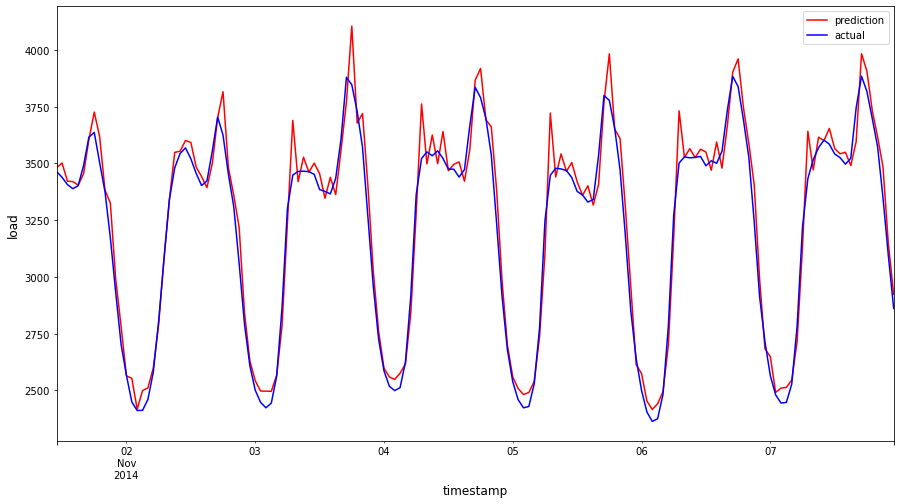

In [18]:
ev_ts_data[ev_ts_data.timestamp < "2014-11-08"].plot(
    x="timestamp", y=["prediction", "actual"], style=["r", "b"], figsize=(15, 8)
)
plt.xlabel("timestamp", fontsize=12)
plt.ylabel("load", fontsize=12)
plt.show()